### Testing how to reproject data from an xarray

rioxarray https://corteva.github.io/rioxarray/stable/ (rasterio and .tif files)

pyresample https://pyresample.readthedocs.io/en/latest/ 

In [10]:
#
import xarray as xr
import rioxarray
import pyresample
import sys
sys.path.append("../")

from src.processing import windsat_datacube

In [4]:
ds = windsat_datacube(folder_path="../data/raw/Daily_Windsat/")

In [24]:
# This only works with rasterio reading (tiff files)
from rasterio.enums import Resampling

# Open a .tif file with rasterio
ds = rioxarray.open_rasterio(
    r"..\data\raw\AMSRU_Mland_2017001A.tif",
    masked=True
)
print("Original sizes")
print(ds.sizes)

# Reproject
rds = ds.rio.reproject(
    ds.rio.crs,
    shape = (720, 1440),
    resampling=Resampling.bilinear
)
print("Reprojected sizes")
print(rds.sizes)


Original sizes
Frozen({'band': 7, 'y': 586, 'x': 1383})
Reprojected sizes
Frozen({'band': 7, 'y': 720, 'x': 1440})


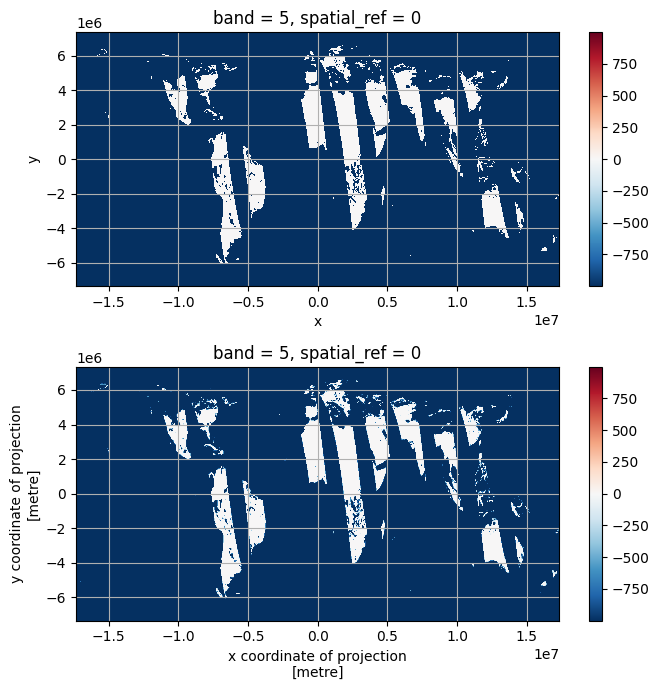

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1,figsize = (7,7))

ds.sel(band=5).plot(ax = ax[0], label = "Original")
rds.sel(band=5).plot(ax = ax[1], label = "Reprojected")
ax[0].grid()
ax[1].grid()

fig.tight_layout()

In [88]:
# Reprojecting Xarray datasets in .nc files
ds = xr.open_dataset(
    "../data/raw/Daily_Windsat/RSS_WINDSAT_DAILY_TBTOA_MAPS_2017_01_01.nc",
    decode_times=False,
)

# Reproject into LPDR_v2 data:

#rename lat and lon grid to x and y:
ds = ds.rename(
    {
        "longitude_grid":"x",
        "latitude_grid": "y"
    }
)

# Se the original CRS since the data array does not have it in metadata:
ds = ds.rio.write_crs("EPSG:4326")

# Set the x and y dimensions as coordinates
ds =ds.set_coords(
    names = ["longitude","latitude"]
)
ds = ds.rename(
    {"longitude" : "x",
    "latitude" : "y"}

)
# Only avaialble with 2D or 3D arrays, we need to select each variable individually
ds = ds["tbtoa"].sel(polarization=0,swath_sector=1, frequency_band =0, look_direction = 0)

rds = ds.rio.reproject("EPSG: 3410")
rds


C:\Users\andre\AppData\Local\Temp\ipykernel_2664\2861358113.py:24: UserWarning: rename 'longitude' to 'x' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename(
C:\Users\andre\AppData\Local\Temp\ipykernel_2664\2861358113.py:24: UserWarning: rename 'latitude' to 'y' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  ds = ds.rename(


<xarray.DataArray 'tbtoa' (y: 627, x: 1483)> Size: 4MB
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [254.53499, 254.54999, 254.575  , ..., 254.415  , 254.435  ,
        254.47499],
       [251.41249, 251.405  , 251.39749, ..., 251.51999, 251.4625 ,
        251.44499],
       ...,
       [227.6525 , 227.545  , 227.465  , ..., 228.055  , 227.9625 ,
        227.845  ],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
  * x            (x) float64 12kB -1.736e+07 -1.733e+07 ... 1.731e+07 1.733e+07
  * y            (y) float64 5kB 7.331e+06 7.307e+06 ... -7.307e+06 -7.33e+06
    spatial_ref  int32 4B 0
Attributes:
    long_name:              TOA brightness temperature
    standard_name:          brightness_temperature
    units:                  Kelvin
    valid_min:              0.0
    valid_max:              330.0
    coverage_content_type:  physicalMeasurement

In [87]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:         (x: 1440, y: 720, swath_sector: 2, look_direction: 2,
                     frequency_band: 5, polarization: 4, polarization_dual: 2)
Coordinates:
    x               (x) float32 6kB ...
    y               (y) float32 3kB ...
    spatial_ref     int32 4B 0
Dimensions without coordinates: swath_sector, look_direction, frequency_band,
                                polarization, polarization_dual
Data variables: (12/32)
    node            (swath_sector) int32 8B ...
    look            (look_direction) int32 8B ...
    frequency_vpol  (frequency_band) float32 20B ...
    frequency_hpol  (frequency_band) float32 20B ...
    eia_nominal     (frequency_band) float32 20B ...
    time            (frequency_band, y, x, look_direction, swath_sector) float64 166MB ...
    ...              ...
    colcld_WSAT     (y, x, swath_sector) float32 8MB ...
    rain_IMERG      (y, x, swath_sector) float32 8MB ...
    rain_WSAT       (y, x, swath_sector) float32 8MB ...
    tran            (polarization_dual, frequency_band, y, x, look_direction, swath_sector) float32 166MB ...
    tbup            (polarization_dual, frequency_band, y, x, look_direction, swath_sector) float32 166MB ...
    tbdw            (polarization_dual, frequency_band, y, x, look_direction, swath_sector) float32 166MB ...
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

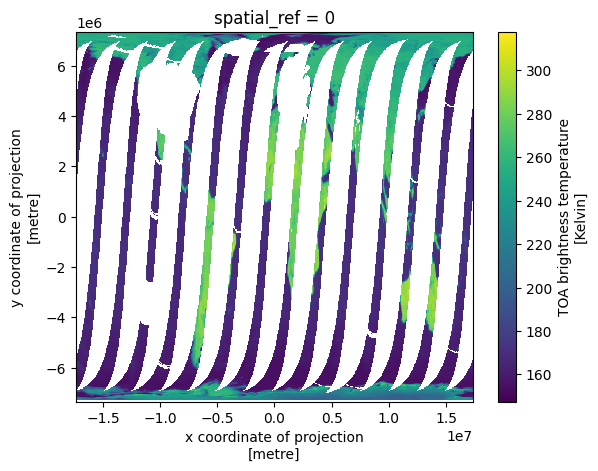

In [89]:
rds.plot()